#### Load LLM

In [1]:
from dotenv import load_dotenv
import guidance
import os

load_dotenv()

api_key = os.getenv("api_key")
organization = os.getenv("organization")

gpt4 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="gpt-4")

#### Ground truth data from Sea Dataset

In [2]:
sea_ice_variables = [
    "geopotential_heights", 
    "relative_humidity", 
    "sea_level_pressure",  
    "zonal_wind_at_10_meters", 
    "meridional_wind_at_10_meters", 
    "sensible_plus_latent_heat_flux", 
    "total_precipitation", 
    "total_cloud_cover", 
    "total_cloud_water_path",  
    "surface_net_shortwave_flux", 
    "surface_net_longwave_flux", 
    "northern_hemisphere_sea_ice_extent",
]

treatment = "surface_net_longwave_flux"
outcome = "northern_hemisphere_sea_ice_extent"

# ground truth confounders to the relationship between surface_net_longwave_flux and northern_hemisphere_sea_ice_extent
ground_truth_confounders = ["total_precipitation"]
   
ground_truth_graph = {
    ("surface_net_longwave_flux", "northern_hemisphere_sea_ice_extent"), 
    
    ("geopotential_heights", "surface_net_longwave_flux"), 
    ("geopotential_heights", "relative_humidity"), 
    ("geopotential_heights", "sea_level_pressure"), 

    ("relative_humidity", "total_cloud_cover"), 
    ("relative_humidity", "total_cloud_water_path"),
    ("relative_humidity", "total_precipitation"), 
    ("relative_humidity", "surface_net_longwave_flux"),

    ("sea_level_pressure", "relative_humidity"), 
    ("sea_level_pressure", "geopotential_heights"), 
    ("sea_level_pressure", "zonal_wind_at_10_meters"), 
    ("sea_level_pressure", "northern_hemisphere_sea_ice_extent"), 
    ("sea_level_pressure", "sensible_plus_latent_heat_flux"), 
    ("sea_level_pressure", "meridional_wind_at_10_meters"),

    ("zonal_wind_at_10_meters", "northern_hemisphere_sea_ice_extent"),
    ("zonal_wind_at_10_meters", "sensible_plus_latent_heat_flux"), 
    
    ("meridional_wind_at_10_meters", "northern_hemisphere_sea_ice_extent"),
    ("meridional_wind_at_10_meters", "sensible_plus_latent_heat_flux"), 
   
    ("sensible_plus_latent_heat_flux", "northern_hemisphere_sea_ice_extent"), 
    ("sensible_plus_latent_heat_flux", "sea_level_pressure"), 
    ("sensible_plus_latent_heat_flux", "zonal_wind_at_10_meters"), 
    ("sensible_plus_latent_heat_flux", "meridional_wind_at_10_meters"), 
    ("sensible_plus_latent_heat_flux", "total_precipitation"), 
    ("sensible_plus_latent_heat_flux", "total_cloud_cover"), 
    ("sensible_plus_latent_heat_flux", "total_cloud_water_path"), 
    
    ("total_precipitation", "northern_hemisphere_sea_ice_extent"),
    ("total_precipitation", "relative_humidity"),
    ("total_precipitation", "sensible_plus_latent_heat_flux"),
    ("total_precipitation", "surface_net_longwave_flux"),
    ("total_precipitation", "total_cloud_cover"),
    ("total_precipitation", "total_cloud_water_path"),
   
    ("total_cloud_water_path", "total_precipitation"), 
    ("total_cloud_water_path", "sensible_plus_latent_heat_flux"), 
    ("total_cloud_water_path", "relative_humidity"), 
    ("total_cloud_water_path", "surface_net_longwave_flux"), 
    ("total_cloud_water_path", "surface_net_shortwave_flux"), 
    
    ("total_cloud_cover", "total_precipitation"),
    ("total_cloud_cover", "sensible_plus_latent_heat_flux"),
    ("total_cloud_cover", "relative_humidity"),
    ("total_cloud_cover", "surface_net_longwave_flux"),
    ("total_cloud_cover", "surface_net_shortwave_flux"), 
    
    ("surface_net_shortwave_flux", "northern_hemisphere_sea_ice_extent"),
    
    ("northern_hemisphere_sea_ice_extent", "sea_level_pressure"),
    ("northern_hemisphere_sea_ice_extent", "zonal_wind_at_10_meters"),
    ("northern_hemisphere_sea_ice_extent", "meridional_wind_at_10_meters"),
    ("northern_hemisphere_sea_ice_extent", "sensible_plus_latent_heat_flux"),
    ("northern_hemisphere_sea_ice_extent", "surface_net_shortwave_flux"),
    ("northern_hemisphere_sea_ice_extent", "surface_net_longwave_flux"),
    }

#### Select random dataset subset

In [3]:
import random 

random.seed(42)  # Set the random seed for reproducibility
subset_size = 7
selected_variables = random.sample(sea_ice_variables[:-2], subset_size)

selected_variables.append(treatment)
selected_variables.append(outcome)  

# grab the relationships that match the subset variables
ground_truth_subset = set()    
for a in selected_variables:
    for b in selected_variables:
        if a != b and (a, b) in ground_truth_graph:
            ground_truth_subset.add((a, b))



The ground truth graph has 27 edges.


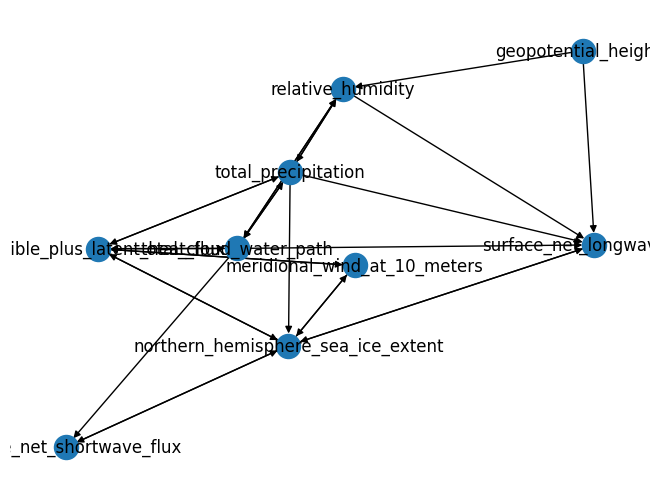

In [4]:
import networkx as nx

ground_truth_subset_graph = nx.DiGraph()
ground_truth_subset_graph.add_nodes_from(selected_variables)
ground_truth_subset_graph.add_edges_from(ground_truth_subset)

'''show graph'''
import matplotlib.pyplot as plt

print(f"The ground truth graph has {len(ground_truth_subset_graph.edges)} edges.")
nx.draw(ground_truth_subset_graph, with_labels=True)
plt.show()

#### Generate Synthetic Dataset

In [5]:
import pandas as pd
import dowhy.datasets

synthetic_data = dowhy.datasets.linear_dataset(
    beta=1,
    treatment_is_binary=False,
    num_common_causes=len(selected_variables)-2,
    num_samples=5000
)

df = synthetic_data['df']
df = df.rename(columns=dict(zip(df.columns, selected_variables)))
print(df.head())

ate = synthetic_data['ate']
print("ATE:", ate)

c:\Users\t-rdesicilia\Documents\VSCodeProjects\Augment\askwhy_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


   relative_humidity  geopotential_heights  meridional_wind_at_10_meters  \
0          -0.525882              0.808477                     -1.142565   
1          -0.749782             -0.674086                      1.196281   
2          -0.564333              2.214564                     -3.179031   
3           2.248458              1.066524                     -0.660483   
4           0.436557              1.630047                     -0.465835   

   surface_net_shortwave_flux  total_precipitation  \
0                   -0.510281             0.505588   
1                   -0.522754             1.024614   
2                   -1.797503             0.531126   
3                    0.151736            -0.246301   
4                    0.143697             0.190936   

   sensible_plus_latent_heat_flux  total_cloud_water_path  \
0                       -0.120890               -0.806083   
1                       -0.947299                1.030601   
2                       -1.131921  

# Modeler

#### Create Modeler

In [6]:
from model_suggester import ModelSuggester
modeler = ModelSuggester()

#### Suggest Confounders

In [7]:
suggested_confounders = modeler.suggest_confounders(variables=selected_variables, llm=gpt4, treatment=treatment, outcome=outcome)

Stop program system You are a helpful assistant on causal reasoning. Your goal is to answer questions about cause and effect in arctic sea ice and atmosphere sciences in a factual and concise way. user Is it true that changing total_cloud_water_path can change surface_net_longwave_flux and northern_hemisphere_sea_ice_extent ? 
 A. Yes
 B. No
 Let's think step-by-step to make sure that we have the right answer. Provide your final answer within the tags, <answer>A/B</answer>. assistant The total cloud water path refers to the amount of liquid water in clouds in a column of the atmosphere. Changes in this can indeed affect the surface net longwave flux, as clouds play a significant role in the Earth's energy balance. They can absorb, reflect, and emit radiation, thus affecting the longwave (infrared) radiation that reaches the surface.

As for the northern hemisphere sea ice extent, it is influenced by a variety of factors, including atmospheric and oceanic temperatures, wind patterns, and ocean currents. While changes in the total cloud water path can affect the Earth's energy balance and thus potentially influence these factors, the relationship is indirect and complex.

So, the answer is:

<answer>A. Yes</answer>

However, it's important to note that while changing total cloud water path can affect these variables, it's not the sole determinant of them. Other factors also play significant roles.

['A. Yes']


In [8]:
suggested_confounders

['relative_humidity',
 'geopotential_heights',
 'surface_net_shortwave_flux',
 'total_precipitation',
 'sensible_plus_latent_heat_flux',
 'total_cloud_water_path']

#### Suggest Pairwise Relationships

In [9]:
relationships_graph = modeler.suggest_relationships(variables=selected_variables, llm=gpt4)

Stop program system You are a helpful assistant on causal reasoning. Your goal is to answer questions about cause and effect in arctic sea ice and atmosphere sciences in a factual and concise way. user Can changing northern_hemisphere_sea_ice_extent change geopotential_heights ?
 A. Yes
 B. No
 Let's think step-by-step to make sure that we have the right answer. Then provide your final answer within the tags, <answer>A/B</answer>. assistant Geopotential height is a measure used in meteorology to understand the altitude of an object, a particle, or a level above mean sea level in the atmosphere. It is influenced by temperature and pressure changes in the atmosphere. 

Changes in the northern hemisphere sea ice extent can influence atmospheric temperatures and pressure. When sea ice melts, it exposes the darker ocean surface, which absorbs more sunlight and heats the atmosphere, changing atmospheric temperature and pressure patterns. This in turn can influence geopotential heights.

So, the answer is:

<answer>A. Yes</answer>

['A. Yes']


#### Full Graph

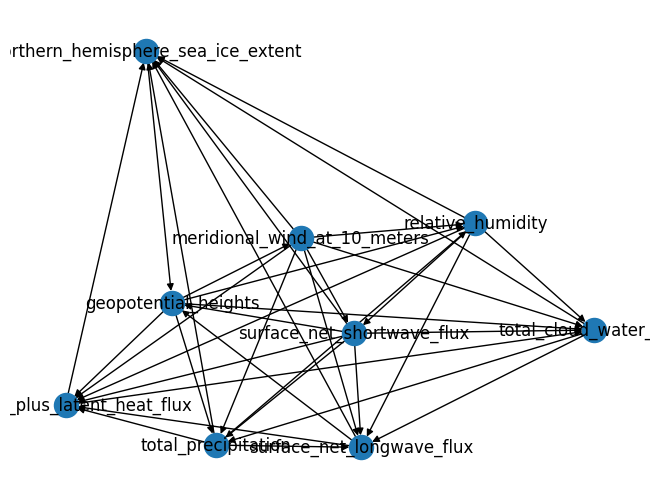

# Modified Modeler

In [11]:
from modified_model_suggester import ModifiedModelSuggester
modified_modeler = ModifiedModelSuggester()

In [12]:
modified_relationships_graph = modified_modeler.suggest_relationships(variables=selected_variables, llm=gpt4)

Stop program system You are a helpful assistant on causal reasoning. Your goal is to answer questions about cause and effect in arctic sea ice and atmosphere sciences in a factual and concise way. user Can changing northern_hemisphere_sea_ice_extent change total_cloud_water_path ?
 In one sentence, make a compelling and factual argument for the relationship between northern_hemisphere_sea_ice_extent and total_cloud_water_path being true. And in another sentence, make a compelling argument for it being false. 
 If no arguemnt can be made for either option, then answer "I don't know" for that option.
 Show your work by explaining how you came to your conclusion. assistant True: Changes in the northern hemisphere sea ice extent can influence the total cloud water path because the reduction of sea ice can increase the evaporation of sea water, leading to a higher moisture content in the atmosphere and potentially more cloud formation.

False: However, the relationship between northern hemisphere sea ice extent and total cloud water path is not straightforward, as cloud formation is influenced by a multitude of factors including atmospheric temperature, pressure, and wind patterns, not just sea ice extent.

Explanation: The relationship between sea ice extent and cloud water path is complex and influenced by many factors. While it's true that less sea ice can lead to more evaporation and potentially more cloud formation, other atmospheric conditions also play a significant role in cloud formation. Therefore, a direct cause-effect relationship cannot be definitively established. user Now, critique the arguments for and against, and consider whether changing northern_hemisphere_sea_ice_extent changes total_cloud_water_path .
 A. Yes
 B. No
 Let's think step-by-step to make sure that we have the right answer. Then provide your final answer within the tags, <answer>A/B</answer>. assistant The argument for the relationship between northern hemisphere sea ice extent and total cloud water path is based on the principle that reduced sea ice can lead to increased evaporation, which in turn can contribute to cloud formation. This is a plausible argument as it is grounded in established scientific principles. However, it assumes a direct and singular relationship between sea ice extent and cloud water path, which may not be the case in reality.

The argument against the relationship acknowledges the complexity of cloud formation, stating that it is influenced by a multitude of factors such as atmospheric temperature, pressure, and wind patterns. This argument is also plausible as it takes into account the multifactorial nature of atmospheric phenomena.

Considering these arguments, it is reasonable to conclude that while changes in northern hemisphere sea ice extent may influence the total cloud water path, it is not the sole determinant. Other factors also play significant roles in cloud formation. Therefore, a change in northern hemisphere sea ice extent does not necessarily directly result in a change in total cloud water path.

<answer>B. No</answer>

['B. No']


#### Full Graph

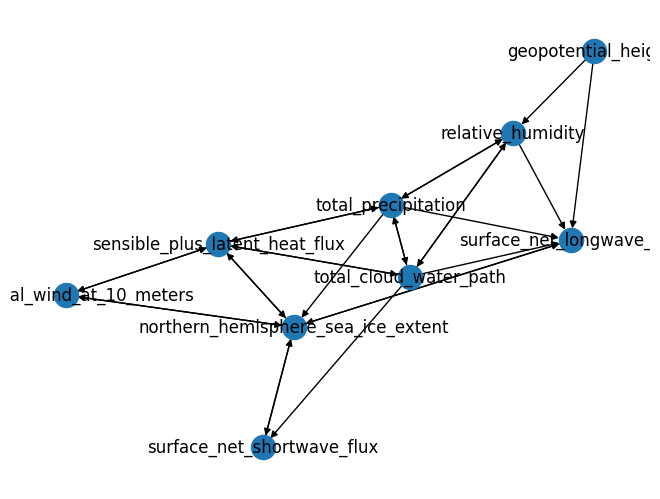

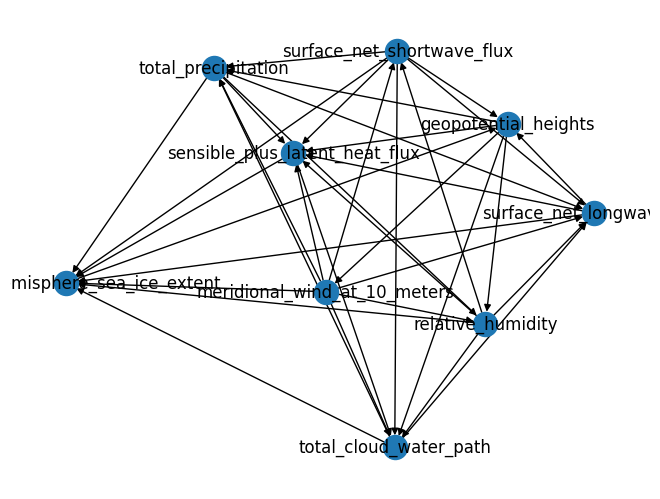

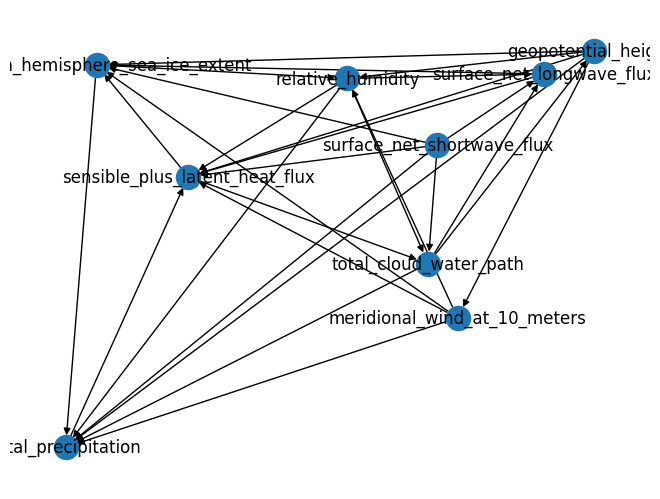

In [13]:
import matplotlib.pyplot as plt
import networkx as nx

nx.draw(ground_truth_subset_graph, with_labels=True)
plt.show()

nx.draw(relationships_graph, with_labels=True)
plt.show()

nx.draw(modified_relationships_graph, with_labels=True)
plt.show()

In [14]:
print(f"Ground truth graph has {len(list(ground_truth_subset_graph.edges))} edges")
print(f"LLM generated graph has {len(list(relationships_graph.edges))} edges")
print(f"Modified promptLLM generated graph has {len(list(modified_relationships_graph.edges))} edges")

Ground truth graph has 27 edges
LLM generated graph has 36 edges
Modified promptLLM generated graph has 28 edges


# Identifier

In [15]:
from identification_suggester import IdentificationSuggester 
from dotenv import load_dotenv
import guidance
import os

load_dotenv()

api_key = os.getenv("api_key")
organization = os.getenv("organization")

# set the default language model used to execute guidance programs
gpt4 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="gpt-4")

#### Create Identifier

In [16]:
identifier = IdentificationSuggester()

#### Suggest Backdoor

In [17]:
backdoor = identifier.suggest_backdoor(llm=gpt4, treatment=treatment, outcome=outcome, confounders=suggested_confounders)
print("Backdoor\n", backdoor)

Stop program system You are a helpful assistant on causal reasoning and arctic sea ice and atmosphere sciences. Your goal is to answer questions factually and concisely about whether and how a causal effect can be estimated using your domain knowledge on artic sea ice and atmosphere sciences. user This variable is a potential confounder. If it were to be conditioned on, would it unbias the surface_net_longwave_flux -> northern_hemisphere_sea_ice_extent causal effect estimation?
 A. Yes
 B. No
 Let's think step-by-step to make sure that we have the right answer. Keep your argument and references to no more than one paragraph, otherwise you lose points, and wrap it within the tags, <explanation>...</explanation>. Then provide your final answer within the tags, <answer>A/B</answer>. assistant <explanation>
A confounder is a variable that influences both the dependent variable and independent variable, causing a spurious association. It's a third variable that affects the causal relationship between the two. Conditioning on a confounder adjusts for its effect and can help provide a more accurate estimate of the causal effect between the independent and dependent variables. In this case, if the variable in question is a confounder for the relationship between surface_net_longwave_flux (independent variable) and northern_hemisphere_sea_ice_extent (dependent variable), conditioning on it would indeed help to unbias the causal effect estimation.
</explanation>

<answer>A</answer>

Backdoor
 ['relative_humidity', 'geopotential_heights', 'surface_net_shortwave_flux', 'total_precipitation', 'sensible_plus_latent_heat_flux', 'total_cloud_water_path']


#### Suggest Frontdoor

In [18]:
frontdoor = identifier.suggest_frontdoor(llm=gpt4, treatment=treatment, outcome=outcome,  confounders=suggested_confounders)
print("Frontdoor\n", frontdoor) 

Stop program system You are a helpful assistant on causal reasoning and arctic sea ice and atmosphere sciences. Your goal is to answer questions factually and concisely about whether and how a causal effect can be estimated using your domain knowledge on artic sea ice and atmosphere sciences. user This variable is a potential confounder. If it were to be conditioned on, would it unbias the surface_net_longwave_flux -> northern_hemisphere_sea_ice_extent causal effect estimation?
 A. Yes
 B. No
 Let's think step-by-step to make sure that we have the right answer. Keep your argument and references to no more than one paragraph, otherwise you lose points, and wrap it within the tags, <explanation>...</explanation>. Then provide your final answer within the tags, <answer>A/B</answer>. assistant <explanation>When estimating a causal effect, controlling for confounding variables helps to ensure that any association observed between the independent and dependent variables is not due to the influence of the confounder. If the variable in question is indeed a confounder between the surface net longwave flux (the independent variable) and northern hemisphere sea ice extent (the dependent variable), then conditioning on it will help remove bias in the estimation of the causal effect. This is under the assumption that all other potential confounders are also properly controlled for, and that there are no mediator variables being controlled for, which could induce bias.</explanation>
<answer>A</answer>

Frontdoor
 ['relative_humidity', 'geopotential_heights', 'surface_net_shortwave_flux', 'total_precipitation', 'sensible_plus_latent_heat_flux', 'total_cloud_water_path']


#### Suggest IVs

In [19]:
iv = identifier.suggest_iv(llm=gpt4, treatment=treatment, outcome=outcome,  confounders=suggested_confounders)
print("Instrumental Variable\n", iv) 

Stop program system You are a helpful assistant on causal reasoning and arctic sea ice and atmosphere sciences. Your goal is to answer questions factually and concisely about whether and how a causal effect can be estimated using your domain knowledge on artic sea ice and atmosphere sciences. user This variable is a potential confounder. If it were to be conditioned on, would it unbias the surface_net_longwave_flux -> northern_hemisphere_sea_ice_extent causal effect estimation?
 A. Yes
 B. No
 Let's think step-by-step to make sure that we have the right answer. Keep your argument and references to no more than one paragraph, otherwise you lose points, and wrap it within the tags, <explanation>...</explanation>. Then provide your final answer within the tags, <answer>A/B</answer>. assistant <explanation>Whether a variable is a confounder depends on its relationship with both the exposure (in this case, surface_net_longwave_flux) and the outcome (northern_hemisphere_sea_ice_extent). A confounder is a variable that is a common cause of both the exposure and outcome. If this variable is indeed a confounder, conditioning on it would help to control for its effect and thus reduce bias in the estimated causal effect of surface_net_longwave_flux on northern_hemisphere_sea_ice_extent. However, it's important to note that this assumes no other unmeasured confounding and that the variable is measured without error.</explanation>

<answer>A</answer>

Instrumental Variable
 ['relative_humidity', 'geopotential_heights', 'surface_net_shortwave_flux', 'total_precipitation', 'sensible_plus_latent_heat_flux', 'total_cloud_water_path']


#### Suggest Estimand


In [20]:
estimand = identifier.suggest_estimand(llm=gpt4,  confounders=suggested_confounders, treatment=treatment, outcome=outcome, backdoor=backdoor, frontdoor=frontdoor, iv=iv)  

In [21]:
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
                                     d                                        
────────────────────────────────────────────────────────────────────────────(E
d[s  u  r  f  a  c  e  _  n  e  t  _  l  o  n  g  w  a  v  e  _  f  l  u  x]  

                                                                              
[n|relative_humidity,geopotential_heights,surface_net_shortwave_flux,total_pre
                                                                              

                                                                  
cipitation,sensible_plus_latent_heat_flux,total_cloud_water_path])
                                                                  
Estimand assumption 1, Unconfoundedness: If U→{s,u,r,f,a,c,e,_,n,e,t,_,l,o,n,g,w,a,v,e,_,f,l,u,x} and U→n then P(n|s,u,r,f,a,c,e,_,n,e,t,_,l,o,n,g,w,a,v,e,_,f,l,u,x,relative_humidity,geopotential_heights,surface_ne

# DoWhy Estimation

In [22]:
import dowhy

# Step 1: Create a causal model from the data and given graph.
model = dowhy.CausalModel(data=df, treatment=treatment, outcome=outcome, graph = ground_truth_subset_graph)


# Step 3: Estimate the treatment effect
causal_estimate = model.estimate_effect(estimand,
        method_name="backdoor.propensity_score_stratification", fit_estimator=False)


AttributeError: 'NoneType' object has no attribute 'predict_proba'

# Validator

In [ ]:
from validation_suggester import ValidationSuggester 
from dotenv import load_dotenv
import guidance
import os

load_dotenv()

api_key = os.getenv("api_key")
organization = os.getenv("organization")

# set the default language model used to execute guidance programs
gpt4 = guidance.llms.OpenAI(api_key=api_key, organization=organization, model="gpt-4")

In [ ]:
validator = ValidationSuggester()

In [ ]:
critiqued_relationships_graph = validator.critique_graph(graph=relationships_graph, llm=gpt4)

critiqued_modified_relationships_graph = validator.critique_graph(graph=modified_relationships_graph, llm=gpt4)

Stop program system You are a helpful assistant on causal reasoning. Your goal is to factually and concisely answer questions about cause and effect relationships using your domain knowledge on artic sea ice and atmosphere sciences. user Analyze the output from an AI assistant. Is the final answer B consistent with the reasoning provided by the assistant?
 
 Question
 Which cause and effect relationship is more likely?
 A. northern_hemisphere_sea_ice_extent causes total_precipitation ?
 B. total_precipitation causes northern_hemisphere_sea_ice_extent ?
 C. Neither. No causal relationship exists. 
 Let's think step-by-step to make sure that we have the right answer. Keep your argument to no more than one paragraph, otherwise you lose points, and wrap it within the tags, <explanation>...</explanation>. Then provide your final answer within the tags, <answer>A/B/C</answer>.
 
 AI Assistant Explanation
 The cause and effect relationship between northern hemisphere sea ice extent and total precipitation is complex and interconnected. However, it is more likely that total precipitation affects the northern hemisphere sea ice extent rather than the other way around. Precipitation, particularly in the form of snow, can contribute to the growth and preservation of sea ice by providing an insulating layer that reduces heat exchange between the ocean and the atmosphere. Meanwhile, the extent of sea ice can influence local weather patterns, but it does not directly cause changes in total precipitation on a global scale. 
 
 Critique the AI Assistant's argument by providing your own individual version of the argument. Provide your explanations within the tags, <explanation>...</explanation> and answer your final answer to the question within the tags, <answer>A/B/C</answer>. assistant <explanation>The AI assistant's reasoning is sound and consistent with the final answer. The relationship between total precipitation and northern hemisphere sea ice extent is indeed complex, but the assistant correctly identifies that total precipitation is more likely to cause changes in sea ice extent. Precipitation, especially snow, can add to the volume of sea ice and provide an insulating layer that reduces heat exchange between the ocean and the atmosphere, thus affecting the extent of sea ice. On the other hand, while sea ice extent can influence local weather patterns, it does not have a direct, large-scale impact on total global precipitation. Therefore, the cause and effect relationship is more likely to be from total precipitation to northern hemisphere sea ice extent.</explanation>

<answer>B</answer>

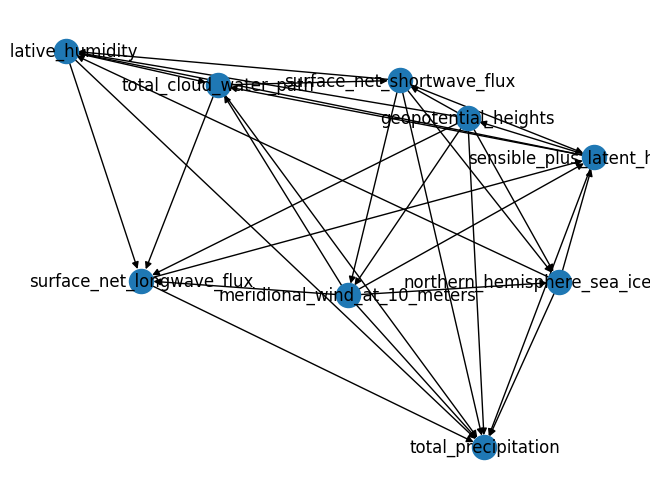

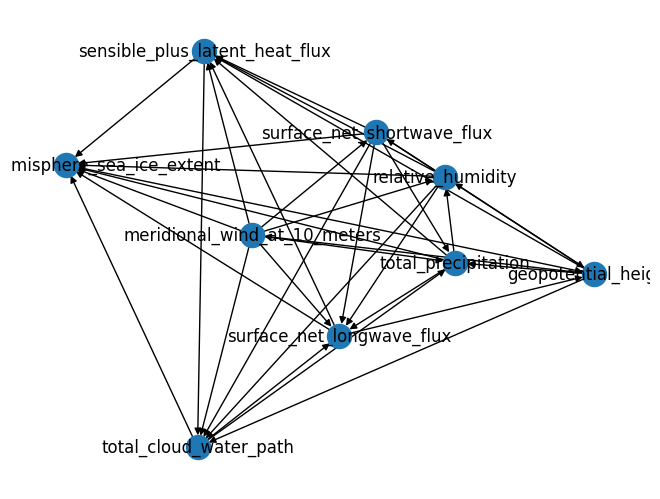

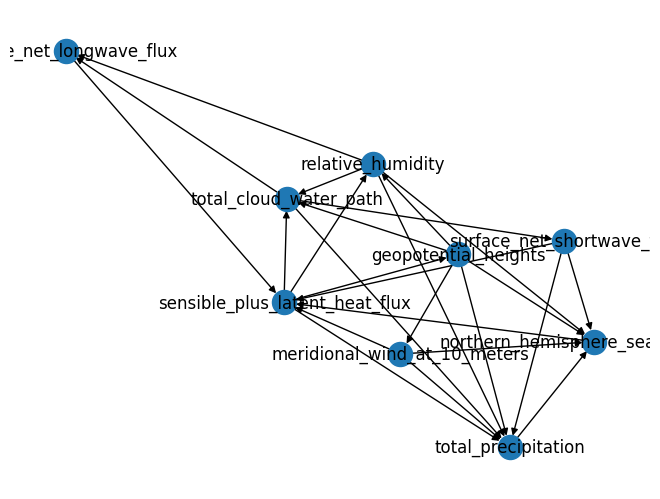

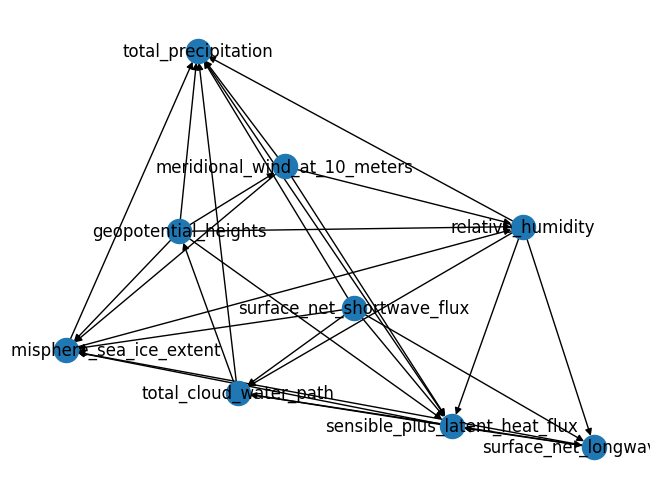

LLM generated graph has 31 edges
LLM generated graph has 36 edges
LLM generated graph has 25 edges
LLM generated graph has 28 edges


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

nx.draw(relationships_graph, with_labels=True)
plt.show()

nx.draw(critiqued_relationships_graph[1], with_labels=True)
plt.show()

nx.draw(modified_relationships_graph, with_labels=True)
plt.show()

nx.draw(critiqued_modified_relationships_graph[1], with_labels=True)
plt.show()

print(f"LLM generated graph has {len(list(relationships_graph.edges))} edges")
print(f"LLM generated graph has {len(list(critiqued_relationships_graph[1].edges))} edges")
print(f"LLM generated graph has {len(list(modified_relationships_graph.edges))} edges")
print(f"LLM generated graph has {len(list(critiqued_modified_relationships_graph[1].edges))} edges")